# Underwater Sound Analysis
## General imports

In [1]:
import os
import csv
import librosa
import soundfile as sf
from collections import Counter
import pandas as pd

 ## In questa fase si estraggono le features, così da salvarle in csv

In [2]:
def extract_audio_features(audio_path):
    
    percorso_normalizzato = os.path.normpath(audio_path)
    elementi = percorso_normalizzato.split(os.sep)
    
    dataset = elementi[0]
    tipo_target = elementi[1]
    nome_target = elementi[2]
    nome_file_audio = elementi[-1]
    
    y, sr = librosa.load(audio_path, sr=None, mono=False)
    duration = librosa.get_duration(y=y, sr=sr)
    channels = 'Mono' if y.ndim == 1 else 'Stereo'
    
    return {'Root': tipo_target, 'Type': nome_target, 'Name': nome_file_audio, 'Durata(s)': duration, 'Canali': channels, 'Frequenza(Hz)': sr}


def scrivi_csv(audio_features, csv_file):
    if not audio_features:
        return  # Se la lista è vuota, non fare nulla

    # Ottieni le chiavi dal primo dizionario per usarle come intestazioni
    keys = audio_features[0].keys()

    with open(csv_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        
        # Scrivi l'intestazione
        writer.writeheader()
        
        # Scrivi le caratteristiche
        for features in audio_features:
            writer.writerow(features)

# Lista per memorizzare i percorsi dei file audio
audio_files = []

# Scorrere ricorsivamente le cartelle nel dataset
for root, dirs, files in os.walk('NuovoDataset/Segmented/Non-Target'):
    for file in files:
        if file.endswith(('.wav','.mp3')):
           audio_files.append(os.path.join(root, file))
audio_features = []

for file in audio_files:

    feature1 = extract_audio_features(file)
    audio_features.append(feature1)
    
#scrittura nel file csv
csv_file = 'Features.csv'
scrivi_csv(audio_features, csv_file)

# Leggi il file CSV con una codifica diversa
df = pd.read_csv('Features.csv', encoding='cp1252')
pd.set_option('display.max_rows', None)
df['Duplicate'] = df.duplicated(keep=False)
# Mostra il dataframe
display(df)

,Root,Type,Name,Durata(s),Canali,Frequenza(Hz),Duplicate
0,Segmented,Non-Target,Arnoux-beaked-whales-rogers-1_segment_0.wav,4.000000,Mono,44100,False
1,Segmented,Non-Target,Arnoux-beaked-whales-rogers-1_segment_1.wav,4.000000,Mono,44100,False
2,Segmented,Non-Target,Arnoux-beaked-whales-rogers-1_segment_2.wav,1.992971,Mono,44100,False
3,Segmented,Non-Target,Arnoux-beaked-whales-rogers-2_segment_0.wav,4.000000,Mono,44100,False
4,Segmented,Non-Target,Arnoux-beaked-whales-rogers-2_segment_1.wav,4.000000,Mono,44100,False
5,Segmented,Non-Target,Arnoux-beaked-whales-rogers-2_segment_2.wav,0.668526,Mono,44100,False
6,Segmented,Non-Target,Arnoux-beaked-whales-rogers-3_segment_0.wav,4.000000,Mono,44100,False
7,Segmented,Non-Target,Arnoux-beaked-whales-rogers-3_segment_1.wav,4.000000,Mono,44100,False
8,Segmented,Non-Target,Arnoux-beaked-whales-rogers-3_segment_2.wav,2.292971,Mono,44100,False
9,Segmented,Non-Target,Arnoux-beaked-whales-rogers-4_segment_0.wav,4.000000,Mono,44100,False


## Somma in secondi degli audio per ciascuna classe
### Serve per capire come gestire la fase di data augumentation

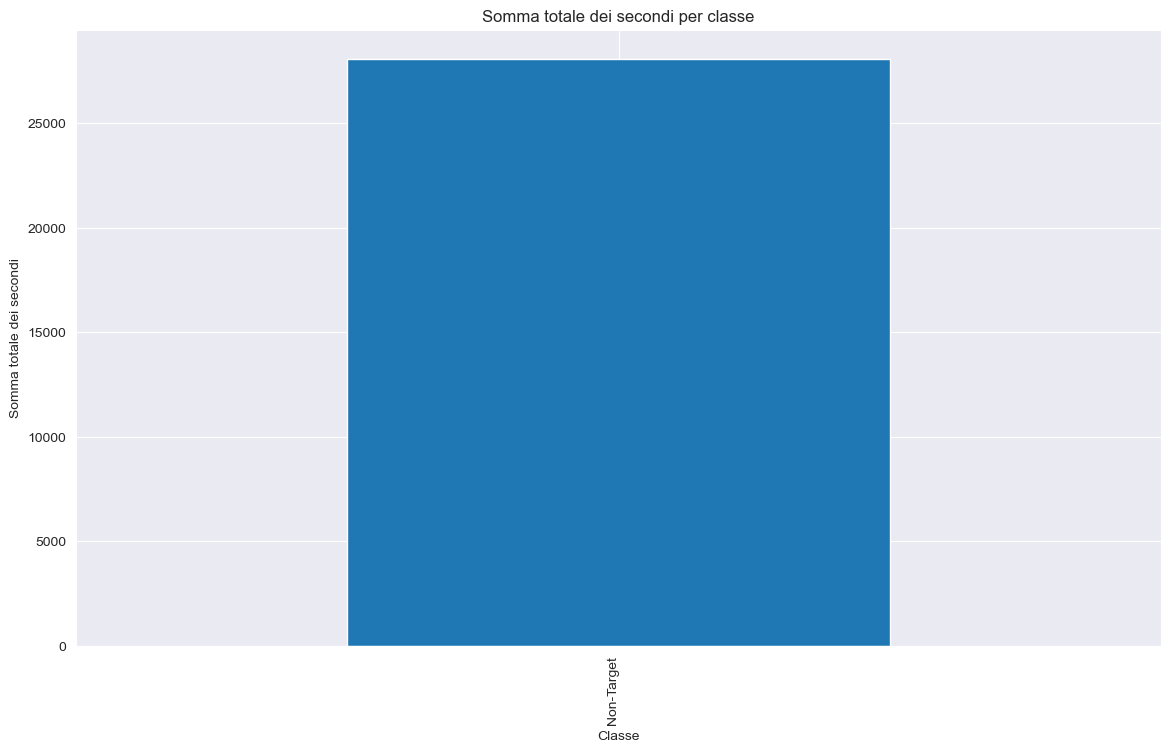

Classi più grandi di 10000s: Type
Non-Target    28072.47959
Name: Durata(s), dtype: float64
Media degli adio filtrati: 28072.479589631246s


In [3]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

df = pd.read_csv(csv_file)
class_duration_sum = df.groupby('Type')['Durata(s)'].sum()

filtered_classes = class_duration_sum[class_duration_sum > 10000]
# Creazione del grafico a barre
plt.figure(figsize=(14, 8))
class_duration_sum.plot(kind='bar')
plt.title('Somma totale dei secondi per classe')
plt.xlabel('Classe')
plt.ylabel('Somma totale dei secondi')
plt.xticks(rotation=90, fontsize=10, horizontalalignment='right')
plt.grid(True)
plt.show()

print(f"Classi più grandi di 10000s: {filtered_classes}")
media_filtered = np.median(filtered_classes)
print(f"Media degli adio filtrati: {media_filtered}s")

## Stampa di tutti gli audio duplicati

In [4]:

file_names = [os.path.basename(file) for file in audio_files]

file_counts = Counter(file_names)
duplicates_info = {}
# Creare un dizionario per mantenere traccia del percorso del file originale
original_paths = {}

for file_path in audio_files:
    file_name = os.path.basename(file_path)
    if file_counts[file_name] > 1:
        if file_name not in duplicates_info:
            duplicates_info[file_name] = {
                "count": file_counts[file_name],
                "paths": [file_path]
            }
            # Memorizza il percorso del file originale
            original_paths[file_name] = file_path
        else:
            duplicates_info[file_name]["count"] += 1
            duplicates_info[file_name]["paths"].append(file_path)

# Stampare informazioni sui file duplicati
total_duplicate_count = sum(info["count"] for info in duplicates_info.values())
print(f"Numero totale di file audio duplicati: {total_duplicate_count/3}")

for file_name, info in duplicates_info.items():
    print(f"Nome del file duplicato: {file_name}")
    print(f"Percorsi duplicati ({info['count']-1}):")
    for path in info["paths"]:
        print(path)
    print(f"Percorso del file originale: {original_paths[file_name]}")
    print()

Numero totale di file audio duplicati: 0.0


## Calcoliamo la distribuzione delle classi

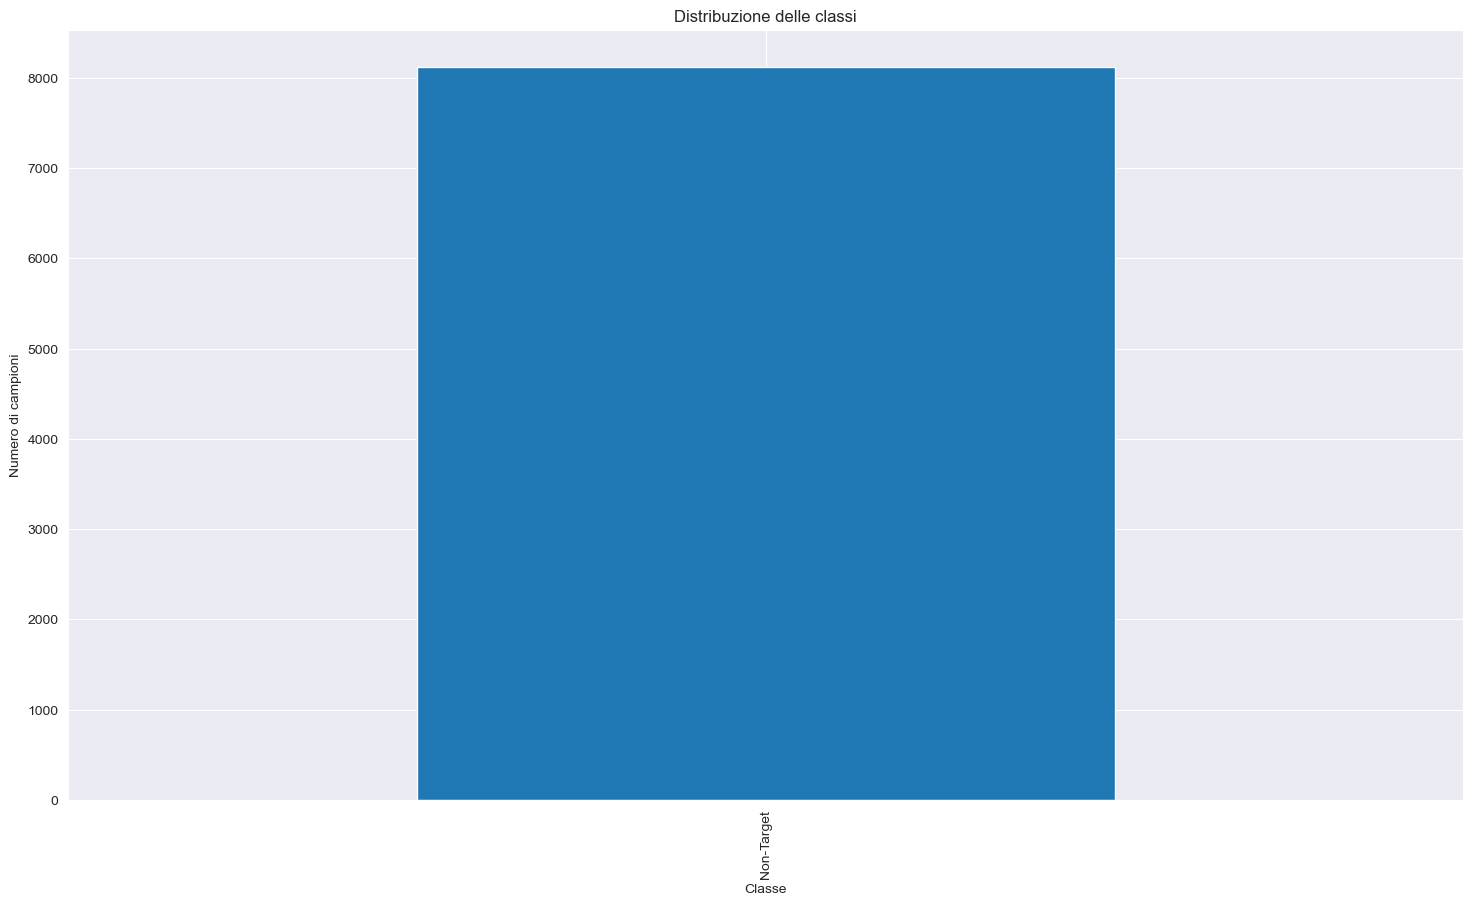

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Esempio di grafico a barre delle classi nel dataset
plt.figure(figsize=(18, 10))
df['Type'].value_counts().plot(kind='bar')
plt.title('Distribuzione delle classi')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.show()

## Distribuzione della durata degli audio


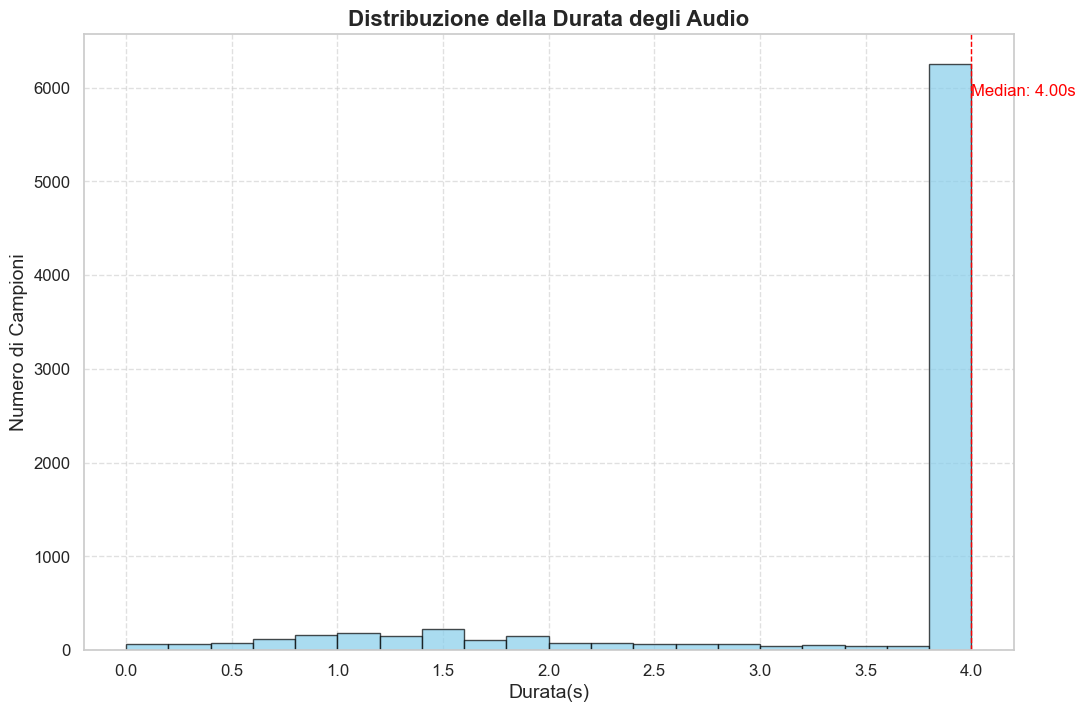

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

# Lista delle durate
durations = [feat['Durata(s)'] for feat in audio_features]

plt.figure(figsize=(12, 8))
plt.hist(durations, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Durata degli Audio', fontsize=16, weight='bold')
plt.xlabel('Durata(s)', fontsize=14)
plt.ylabel('Numero di Campioni', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiunta annotazioni
median_duration = np.median(durations)
plt.axvline(median_duration, color='red', linestyle='dashed', linewidth=1)
plt.text(median_duration, plt.ylim()[1] * 0.9, f'Median: {median_duration:.2f}s', color='red', fontsize=12)

# Aggiungi griglia
plt.grid(True, linestyle='--', alpha=0.6)

# Visualizza il grafico
plt.show()


## Distribuzione delle frequenze audio
### Si usa per capire a quale frequenza ricampionare

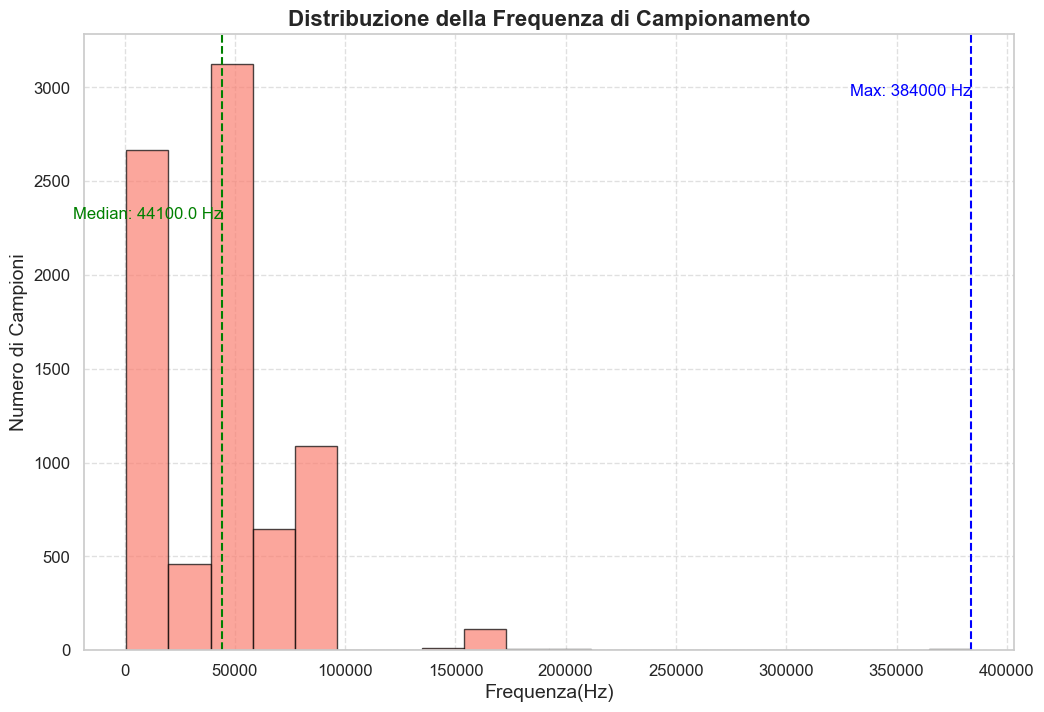

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate

# Imposta il tema di Seaborn per migliorare l'estetica
sns.set_theme(style="whitegrid")

# Frequenze di campionamento (assumendo che audio_features sia definito)
frequencies = [feat['Frequenza(Hz)'] for feat in audio_features]

# Creazione del grafico della distribuzione della frequenza di campionamento
plt.figure(figsize=(12, 8))  # Dimensioni maggiori per una migliore leggibilità
plt.hist(frequencies, bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Frequenza di Campionamento', fontsize=16, weight='bold')
plt.xlabel('Frequenza(Hz)', fontsize=14)
plt.ylabel('Numero di Campioni', fontsize=14)

# Migliora le etichette degli assi
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungi annotazioni per la frequenza massima e la mediana
freq_max = max(frequencies)
median_freq = np.median(frequencies)
plt.axvline(freq_max, color='blue', linestyle='dashed', linewidth=1.5)
plt.axvline(median_freq, color='green', linestyle='dashed', linewidth=1.5)
plt.text(freq_max, plt.ylim()[1] * 0.9, f'Max: {freq_max} Hz', color='blue', fontsize=12, ha='right')
plt.text(median_freq, plt.ylim()[1] * 0.7, f'Median: {median_freq} Hz', color='green', fontsize=12, ha='right')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

hist, bins = np.histogram(frequencies, bins=20)





### La mediana è il valore centrale che separa la metà superiore dei dati dalla metà inferiore. Essa non è influenzata dai valori anomali, come la media, e fornisce una misura più rappresentativa della frequenza di campionamento tipica.

In [8]:
tabella_dati = []
for i in range(len(hist)):
    tabella_dati.append((f"{bins[i]:.2f} - {bins[i+1]:.2f} Hz", hist[i]))
# Stampa della tabella
print(tabulate(tabella_dati, headers=["Intervallo di frequenza", "Numero di campioni"], tablefmt="pretty"))

+--------------------------+--------------------+
| Intervallo di frequenza  | Numero di campioni |
+--------------------------+--------------------+
|   600.00 - 19770.00 Hz   |        2665        |
|  19770.00 - 38940.00 Hz  |        458         |
|  38940.00 - 58110.00 Hz  |        3127        |
|  58110.00 - 77280.00 Hz  |        645         |
|  77280.00 - 96450.00 Hz  |        1089        |
| 96450.00 - 115620.00 Hz  |         0          |
| 115620.00 - 134790.00 Hz |         0          |
| 134790.00 - 153960.00 Hz |         14         |
| 153960.00 - 173130.00 Hz |        115         |
| 173130.00 - 192300.00 Hz |         4          |
| 192300.00 - 211470.00 Hz |         4          |
| 211470.00 - 230640.00 Hz |         0          |
| 230640.00 - 249810.00 Hz |         0          |
| 249810.00 - 268980.00 Hz |         0          |
| 268980.00 - 288150.00 Hz |         0          |
| 288150.00 - 307320.00 Hz |         1          |
| 307320.00 - 326490.00 Hz |         0          |


### qui spieghiamo perché scegliamo di campionare a determinati Hz

In [9]:
statistiche_frequenze = [
    ("Frequenza massima", freq_max),
    ("Mediana delle frequenze", median_freq)
]

print(tabulate(statistiche_frequenze, headers=["Statistiche", "Valore (Hz)"], tablefmt="pretty"))

+-------------------------+-------------+
|       Statistiche       | Valore (Hz) |
+-------------------------+-------------+
|    Frequenza massima    |   384000    |
| Mediana delle frequenze |   44100.0   |
+-------------------------+-------------+


## Serve per vedere i percorsi degli audio che andremo a tagliare

In [10]:
def estrai_path_e_conta_frequenze(audio_features, frequenza_minima):
    # Filtra i file audio per la frequenza di campionamento minima specificata
    # paths = [feat['Audio'] for feat in audio_features if feat['Frequenza(Hz)'] >= frequenza_minima]
    paths = [
        f"Dataset/{feat['Root']}/{feat['Type']}/{feat['Name']}" 
        for feat in audio_features 
        if feat['Frequenza(Hz)'] >= frequenza_minima
    ]
    total_frequencies = len(paths)
    return paths, total_frequencies

# Frequenza minima desiderata (Hz)
frequenza_minima = 200001

# Estrazione dei path e conteggio delle frequenze per la frequenza minima specificata
paths, total_frequencies = estrai_path_e_conta_frequenze(audio_features, frequenza_minima)

# Stampa dei percorsi estratti
print(f"Percorsi dei file audio con frequenza di campionamento ≥ {frequenza_minima} Hz:")
for path in paths:
    print(path)

# Stampa del numero totale di frequenze trovate
print(f"\nNumero totale di frequenze trovate: {total_frequencies}")

Percorsi dei file audio con frequenza di campionamento ≥ 200001 Hz:
Dataset/Segmented/Non-Target/bottlenose_dolphin_clicks_segment_0.wav
Dataset/Segmented/Non-Target/Sue-clipped_P-_20130619_124456-copy_1_segment_0.wav
Dataset/Segmented/Non-Target/Sue-clipped_P-_20130619_124456-copy_1_segment_1.wav
Dataset/Segmented/Non-Target/Sue-P-_20130619_122308-copy_1_segment_0.wav
Dataset/Segmented/Non-Target/Sue-P-_20130619_122308-copy_1_segment_1.wav

Numero totale di frequenze trovate: 5


qui evidenziamo quali audio superano una determinata soglia

## Mono/Stereo counting

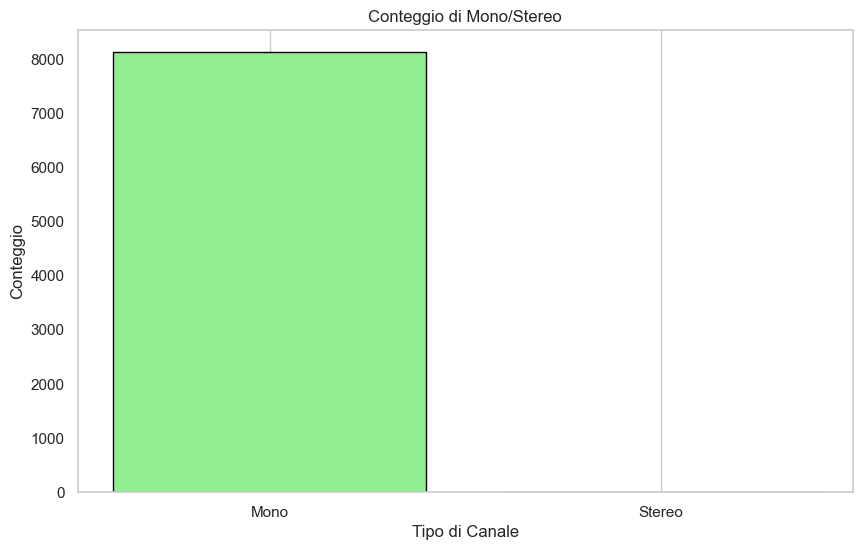

In [11]:
channels = [feat['Canali'] for feat in audio_features]

# Grafico del conteggio di mono/stereo
plt.figure(figsize=(10, 6))
plt.bar(['Mono', 'Stereo'], [channels.count('Mono'), channels.count('Stereo')], color=['lightgreen', 'lightcoral'], edgecolor=['black','black'])
plt.title('Conteggio di Mono/Stereo')
plt.xlabel('Tipo di Canale')
plt.ylabel('Conteggio')
plt.grid(axis='y')
plt.show()

## Depth Bit Counts

### Durante l'analisi del dataset abbiamo trovato file di tipo mp3 e wav. Il bit depth è un concetto applicabile solamente ai file wav mentre i file mp3 vengono compressi e di conseguenza hanno il bitrate. Il bitrate è l'unità di misura che quantifica la quantità di audio compressi al secondo, non utili alle analisi di nostro interesse.

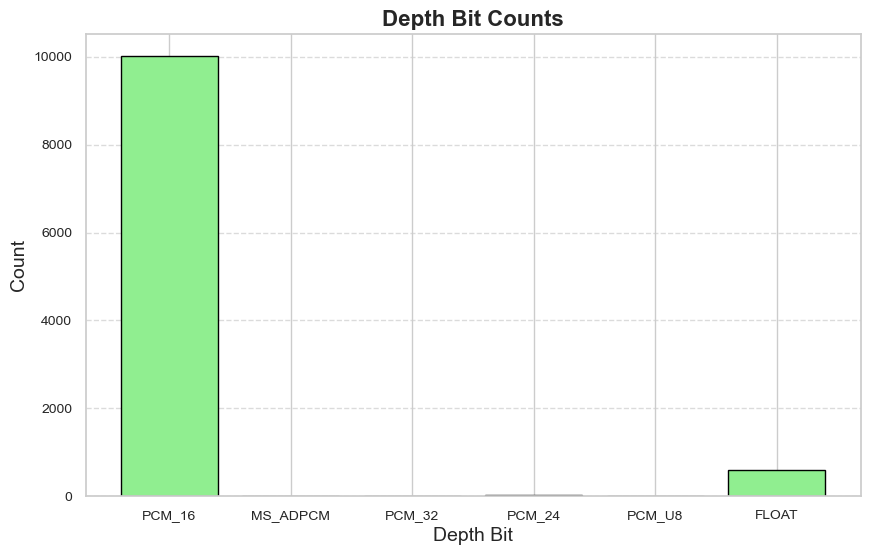

In [12]:
for root, dirs, files in os.walk('Dataset'):
    for file in files:
        if file.endswith(('.wav')):
           audio_files.append(os.path.join(root, file))
# Creare un dizionario per tenere traccia del conteggio di ciascun valore
depth_bit_counts = {}

for file in audio_files:
    audio = sf.SoundFile(file)
    depth_bit = audio.subtype
    
    # Aggiungere il valore al dizionario o incrementare il conteggio se già presente
    if depth_bit in depth_bit_counts:
        depth_bit_counts[depth_bit] += 1
    else:
        depth_bit_counts[depth_bit] = 1

# Estrai i dati per il grafico
depth_bits = list(depth_bit_counts.keys())
counts = list(depth_bit_counts.values())

# Creare il grafico a barre con dimensioni specificate
plt.figure(figsize=(10, 6))  # Imposta la dimensione della figura a 12x8 pollici
plt.bar(depth_bits, counts, color='lightgreen', edgecolor='black')
plt.xlabel('Depth Bit', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Depth Bit Counts', fontsize=16, weight='bold')

# Migliora le etichette degli assi
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungi una griglia per migliorare la leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()

### Durante l'analisi del dataset abbiamo trovato file di tipo mp3 e wav. Il bit depth è un concetto applicabile solamente ai file wav mentre i file mp3 vengono compressi e di conseguenza hanno il bitrate. Il bitrate è l'unità di misura che quantifica la quantità di audio compressi al secondo, non utili alle analisi di nostro interesse.
 